In [22]:
import nltk
from nltk.stem import *

import pandas as pd
import numpy as np

from sklearn.datasets import fetch_20newsgroups

import re

import gensim
import pickle 

from gensim.models import CoherenceModel

import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.gensim_models

In [23]:
nltk.download('punkt') 
nltk.download('wordnet') 
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dsimbandumwe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dsimbandumwe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dsimbandumwe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/dsimbandumwe/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [24]:
stopwords = set(nltk.corpus.stopwords.words('english'))

# Functions

In [25]:
def remove_url(text):
    return re.sub(r'https?:\S*','',text)


def remove_mentions_and_tags(text):
     text = re.sub(r'@\S*','',text)
     return re.sub(r'#\S*','',text)


def text_preprocessing(df):
    corpus=[]
    
    lem = WordNetLemmatizer() # For Lemmatization
    for news in df['text']:
        words=[w for w in nltk.tokenize.word_tokenize(news) if (w not in stopwords)] # word_tokenize function tokenizes text on each word by default
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        corpus.append(words)
    return corpus





# Download

In [26]:
fetch20newsgroups = fetch_20newsgroups(subset='train')

In [27]:
df = pd.DataFrame(fetch20newsgroups.data, columns=['text'])

# Clean Data

In [28]:
df.text = df.text.apply(remove_url)

In [29]:
df.text = df.text.apply(remove_mentions_and_tags)

# Pre-Processing

In [30]:
# Apply this function on our data frame
corpus = text_preprocessing(df)

In [31]:
# Transform to gensim dictionary
dic = gensim.corpora.Dictionary(corpus) 
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

# Useful for storing big datasets
pickle.dump(bow_corpus, open('./data/corpus.pkl', 'wb'))
dic.save('./data/dictionary.gensim')

# Model

In [32]:
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                   num_topics = 4,
                                    id2word = dic,
                                      passes = 10,
                                      workers = 2)
lda_model.save('./data/model4.gensim')

In [33]:
# We print words occuring in each of the topics as we iterate through them
for idx, topic in lda_model.print_topics(num_words=10):    
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.009*"From" + 0.008*"Subject" + 0.008*"The" + 0.008*"Lines" + 0.008*"Organization" + 0.006*"n't" + 0.004*"University" + 0.004*"..." + 0.004*"one" + 0.004*"would"
Topic: 1 
Words: 0.009*"n't" + 0.009*"The" + 0.006*"would" + 0.005*"one" + 0.005*"people" + 0.005*"From" + 0.004*"Subject" + 0.004*"writes" + 0.004*"Lines" + 0.004*"Organization"
Topic: 2 
Words: 0.349*"'AX" + 0.026*"MAX" + 0.005*"Q,3" + 0.005*"A86" + 0.005*"B8F" + 0.004*"145" + 0.003*"1D9" + 0.002*"2DI" + 0.002*"BHJ" + 0.002*"PL+"
Topic: 3 
Words: 0.007*"From" + 0.007*"Subject" + 0.007*"Lines" + 0.006*"Organization" + 0.005*"The" + 0.005*"writes" + 0.005*"n't" + 0.005*"article" + 0.004*"..." + 0.004*"University"


# Evaluation

In [34]:
# instantiate topic coherence model
cm = CoherenceModel(model=lda_model, corpus=bow_corpus, texts=corpus, coherence='c_v')

In [35]:
# get topic coherence score
coherence_lda = cm.get_coherence()
print(coherence_lda)

0.6461315175172017


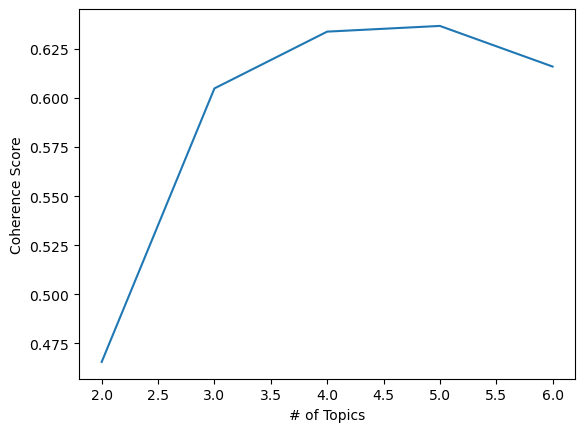

In [36]:
topics = []
score = []
for i in range(2,7,1):
     lda = gensim.models.LdaMulticore(corpus=bow_corpus, id2word=dic, iterations=10, num_topics=i, workers = 3, passes=10, random_state=42)
     cm = CoherenceModel(model=lda, corpus=bow_corpus, texts=corpus, coherence='c_v')
     topics.append(i) # Append number of topics modeled
     score.append(cm.get_coherence()) # Append coherence scores to list
plt.plot(topics, score)
plt.xlabel('# of Topics')
plt.ylabel('Coherence Score')
plt.show()

In [37]:
# Loading the dictionary and corpus files we saved earlier
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('./data/corpus.pkl', 'rb'))

In [38]:
# Loading the num_of_topics = 2 model we saved earlier
lda = gensim.models.ldamodel.LdaModel.load('model4.gensim')
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda, bow_corpus, dic, sort_topics=False)
pyLDAvis.display(vis)